### Setul de date - https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
Cancerul de sân este una dintre cele mai frecvente cauze de deces în rândul femeilor la nivel mondial. Detectarea precoce ajută la reducerea numărului de decese timpurii. Datele analizează imaginile medicale ale cancerului de sân utilizând scanări cu ultrasunete. Setul de date Breast Ultrasound Dataset este clasificat în trei categorii: imagini normale, benigne și maligne. Imaginile cu ultrasunete mamare pot produce rezultate excelente în clasificarea, detectarea și segmentarea cancerului de sân atunci când sunt combinate cu învățarea automată.

Datele colectate inițial includ imagini cu ultrasunete mamare de la femei cu vârste cuprinse între 25 și 75 de ani. Aceste date au fost colectate în 2018. Numărul de paciente este de 600 de femei. Setul de date constă în 780 de imagini, cu o dimensiune medie de 500x500 pixeli. Imaginile sunt în format PNG. Imaginile de referință sunt prezentate împreună cu imaginile originale. Acestea sunt clasificate în trei categorii: normale, benigne și maligne.

Scopul laboratorului de astăzi este să testăm diferite modele preantrenate și să le ajustăm pentru task-ul nostru specific.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

from PIL import Image
from collections import Counter
from torchvision import models

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")

import glob

from sklearn.model_selection import train_test_split

In [24]:
!unzip breast-ultrasound-images-dataset.zip

Archive:  breast-ultrasound-images-dataset.zip
replace Dataset_BUSI_with_GT/benign/benign (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [25]:
masks = glob.glob("Dataset_BUSI_with_GT/*/*_mask.png")
images = [mask_images.replace("_mask", "") for mask_images in masks]
labels = []
for image_path in images:
    if 'benign' in image_path:
        labels.append(0)
    elif 'normal' in image_path:
        labels.append(1)
    elif 'malignant' in image_path:
        labels.append(2)

series = list(zip(images, masks, labels))

## Pastea I - Clasificare

### Exercitiul 1
Implementați funcția *plot_train_label* care primește ca parametru un tuplu ce conține calea către imaginea originală, masca sa de segmentare și eticheta (0 - benign, 1 - normal, 2 - malign).

In [26]:
def plot_train_label(image_mask):
    image = cv2.imread(image_mask[0])
    mask = cv2.imread(image_mask[1])

    #TO DO
    label = image_mask[2]

    label_map = {0: "benign", 1: "normal", 2: "malignant"}
    label_text = label_map.get(label, str(label))

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title(f"Image - {label_text}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_gray, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

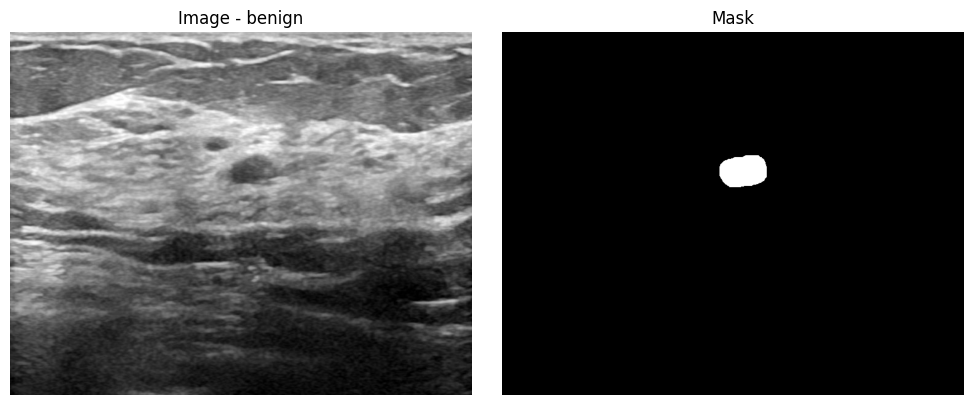

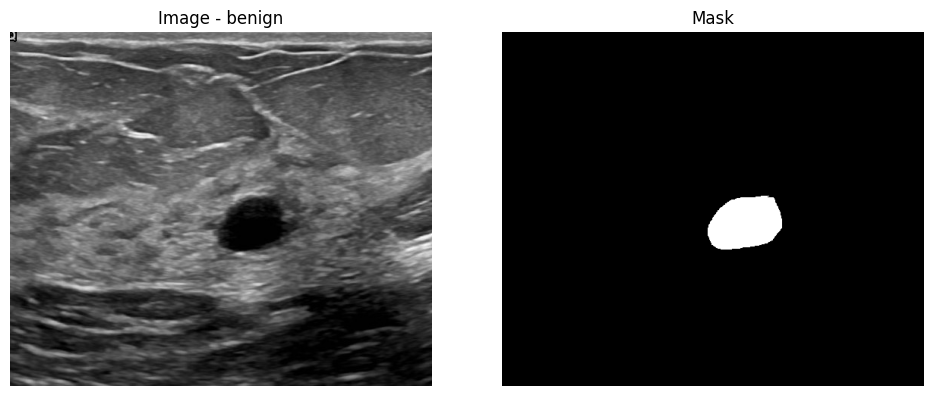

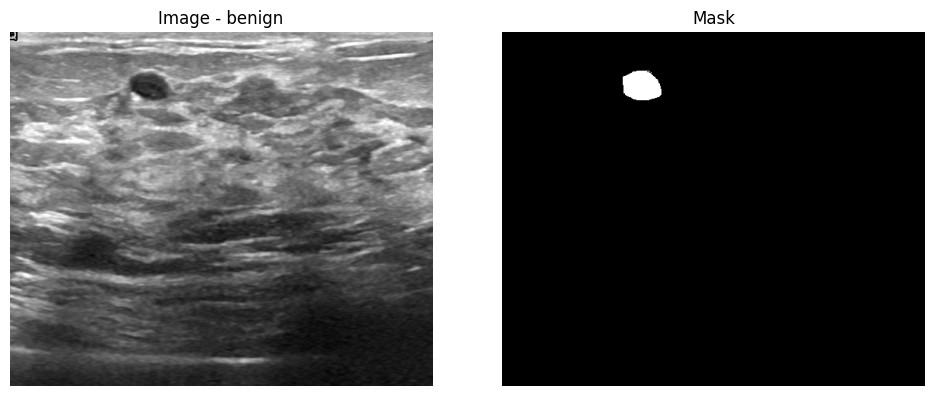

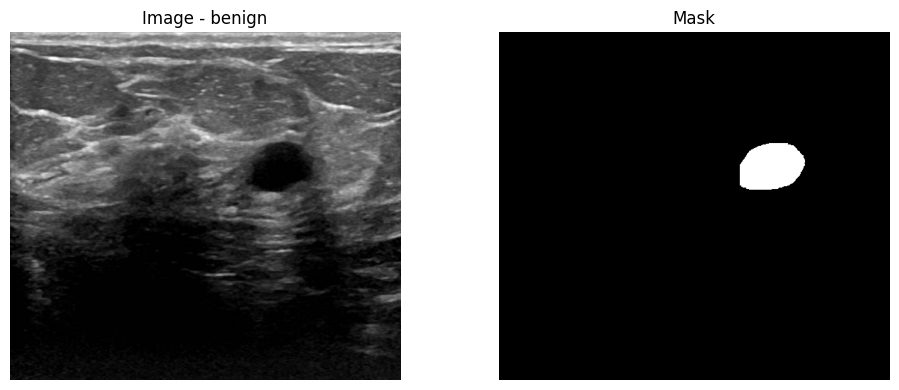

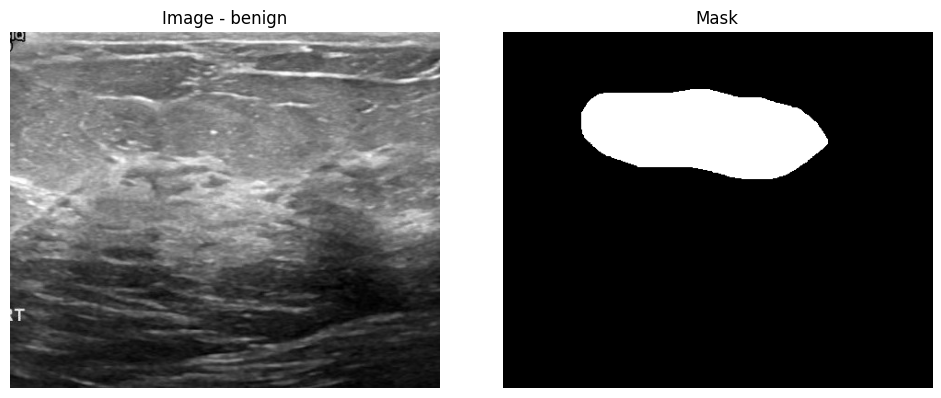

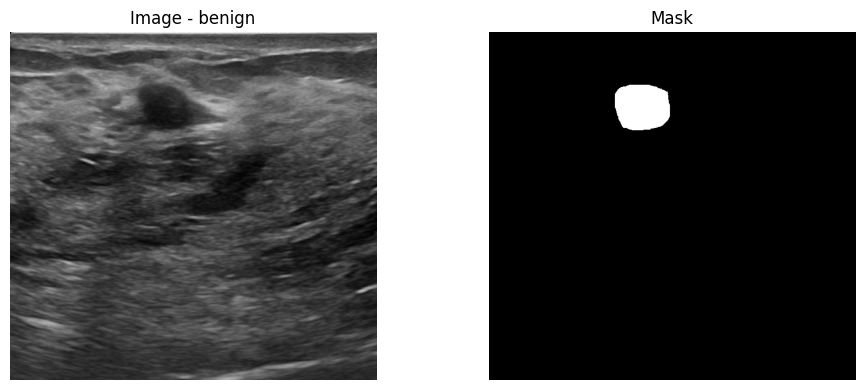

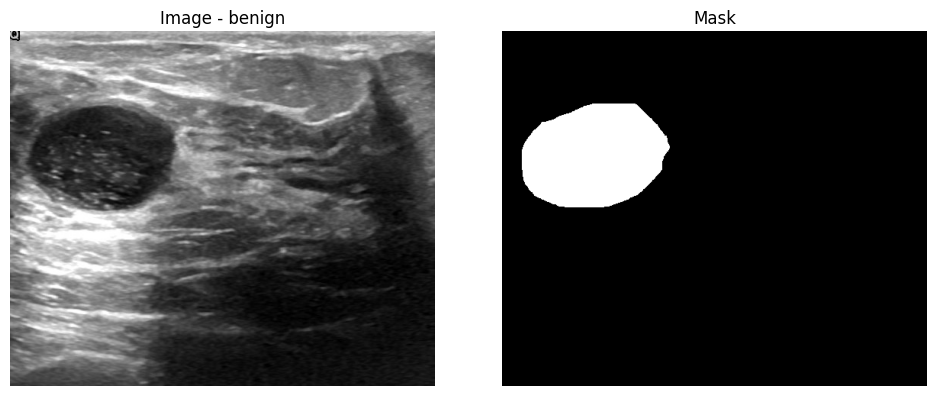

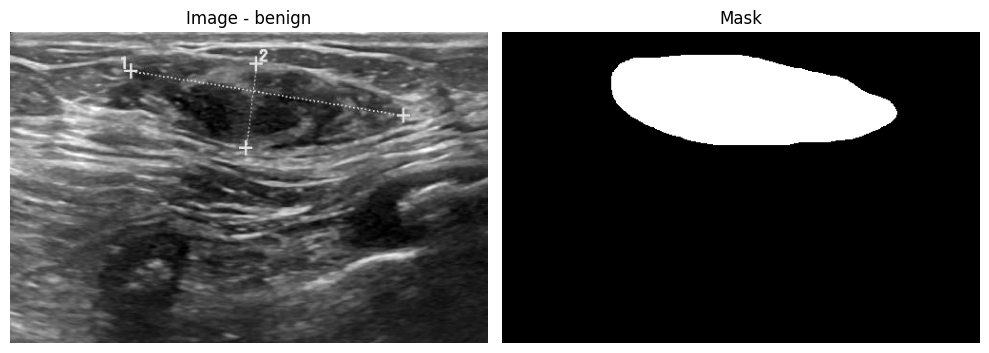

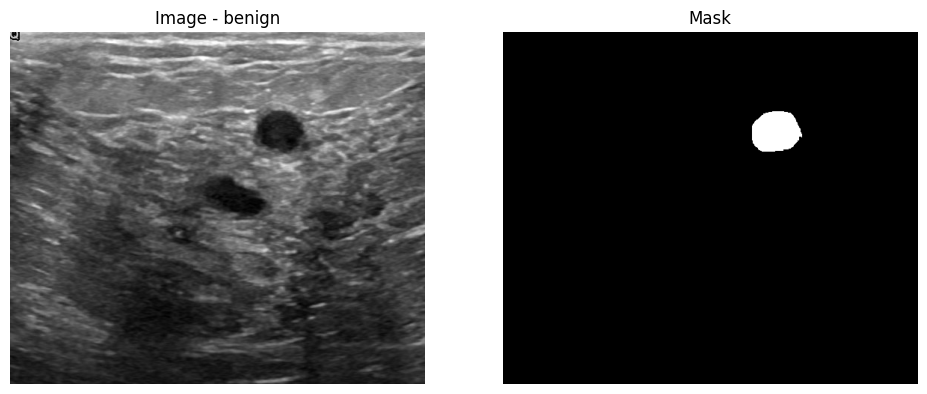

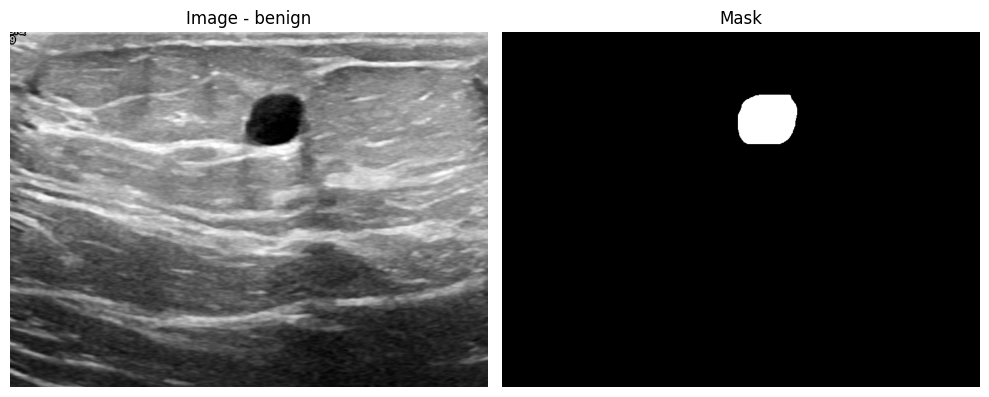

In [27]:
# afisarea a 10 imagini random
random_image = random.sample(range(10), 10)
for image in random_image:
    plot_train_label(series[image])

In [28]:
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path','labels'])

In [29]:
dataset = dataset[['image_path', 'labels']]

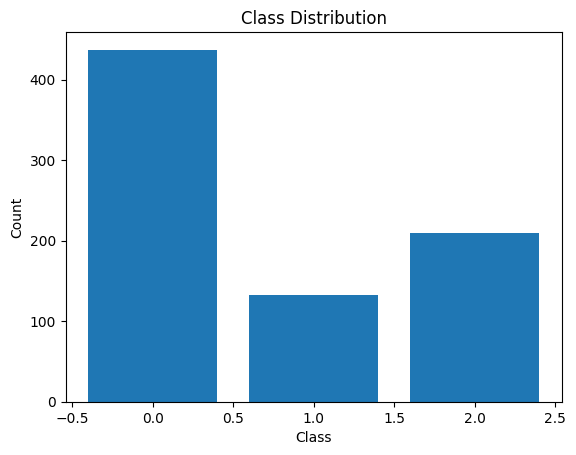

In [30]:
class_counts = dataset['labels'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [31]:
dataset

,image_path,labels
0,Dataset_BUSI_with_GT/benign/benign (27).png,0
1,Dataset_BUSI_with_GT/benign/benign (53).png,0
2,Dataset_BUSI_with_GT/benign/benign (24).png,0
3,Dataset_BUSI_with_GT/benign/benign (304).png,0
4,Dataset_BUSI_with_GT/benign/benign (166).png,0
...,...,...
775,Dataset_BUSI_with_GT/malignant/malignant (133)...,2
776,Dataset_BUSI_with_GT/malignant/malignant (80).png,2
777,Dataset_BUSI_with_GT/malignant/malignant (2).png,2
778,Dataset_BUSI_with_GT/malignant/malignant (83).png,2


In [32]:
# Define paths
aug_path = 'augmented_images/'
image_paths = dataset['image_path'].values
labels = dataset['labels'].values

# Create augmented data folder if it doesn't exist
if not os.path.exists(aug_path):
    os.makedirs(aug_path)

# Count the number of samples in each class
label_counts = Counter(labels)

# Calculate the target number of samples for each class (use the maximum count)
target_count = max(label_counts.values())

# Create image augmentation transforms
combined_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

In [33]:
label_counts[0] - label_counts[1]

304

In [34]:
for i in [1, 2]:
    num_augmentations = label_counts[0] - label_counts[i]
    image_paths = dataset.loc[dataset['labels'] == i, 'image_path'].values
    for j in range(num_augmentations):
        random_index = random.randint(0, len(image_paths) - 1)
        image_path = image_paths[random_index]
        image = Image.open(image_path)
        rotated_image = combined_transform(image.copy())

        rotated_image_np = np.array(rotated_image)
        image_name = os.path.basename(image_path)
        aug_image_path = os.path.join(aug_path, f'{image_name[:-4]}.png')

        cv2.imwrite(aug_image_path, rotated_image_np)

In [35]:
images = glob.glob("augmented_images/*.png")
labels = []
for image_path in images:
    if 'benign' in image_path:
        labels.append(0)
    elif 'normal' in image_path:
        labels.append(1)
    elif 'malignant' in image_path:
        labels.append(2)

new_series = list(zip(images, labels))
dataset_ = pd.DataFrame(new_series, columns=['image_path','labels'])

In [36]:
concatenated_df = pd.concat([dataset, dataset_], axis=0, ignore_index=True)

In [37]:
concatenated_df

,image_path,labels
0,Dataset_BUSI_with_GT/benign/benign (27).png,0
1,Dataset_BUSI_with_GT/benign/benign (53).png,0
2,Dataset_BUSI_with_GT/benign/benign (24).png,0
3,Dataset_BUSI_with_GT/benign/benign (304).png,0
4,Dataset_BUSI_with_GT/benign/benign (166).png,0
...,...,...
1031,augmented_images/malignant (24).png,2
1032,augmented_images/normal (48).png,1
1033,augmented_images/normal (6).png,1
1034,augmented_images/malignant (63).png,2


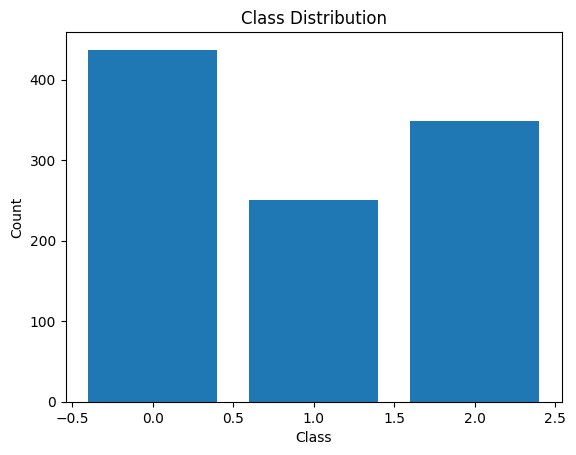

In [38]:
class_counts = concatenated_df['labels'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [39]:
train, test= train_test_split(concatenated_df, test_size=0.3)
test, validation = train_test_split(test, test_size=0.5)

In [40]:
class CustomImageMaskDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        label = self.data.iloc[idx]['labels']

        image = Image.open(image_path).convert('RGB')

        if self.image_transform:
            image = self.image_transform(image)

        return image, label

In [41]:
image_size = 256

train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])


# Create datasets
train_dataset = CustomImageMaskDataset(train, train_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)
val_dataset = CustomImageMaskDataset(validation, val_transforms)

# Create DataLoaders
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [42]:
for batch in train_dataloader:
    inputs, targets = batch

    # Print the shapes
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16])


In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [44]:
class Trainer:
    def __init__(self, model, optimizer, criterion, device='cuda'):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.metrics = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0.0
        correct_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_predictions / len(train_loader.dataset)
        return epoch_loss, epoch_accuracy

    def evaluate(self, val_loader):
        self.model.eval()
        total_loss = 0.0
        correct_predictions = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()

        epoch_loss = total_loss / len(val_loader)
        epoch_accuracy = correct_predictions / len(val_loader.dataset)
        return epoch_loss, epoch_accuracy

    def train(self, train_loader, val_loader, num_epochs=10):
        for epoch in range(num_epochs):
            train_loss, train_accuracy = self.train_epoch(train_loader)
            val_loss, val_accuracy = self.evaluate(val_loader)

            print(f'Epoch {epoch + 1}/{num_epochs} => '
                  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | '
                  f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

            # Save metrics
            self.metrics['train_loss'].append(train_loss)
            self.metrics['train_accuracy'].append(train_accuracy)
            self.metrics['val_loss'].append(val_loss)
            self.metrics['val_accuracy'].append(val_accuracy)

    def get_metrics(self):
        return self.metrics


### Exercitiul 2
Definiți modelele VGG16, VGG19 și EfficientNet_B7 din torchvision.

In [45]:
from torchvision import models

# TODO
model_vgg16 = models.vgg16(pretrained=True)
model_vgg19 = models.vgg19(pretrained=True)
model_effnet = models.efficientnet_b7(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 149MB/s]


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:05<00:00, 104MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth


100%|██████████| 255M/255M [00:02<00:00, 129MB/s]


In [46]:
vgg_classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 3)
)

model_vgg16.classifier = vgg_classifier
model_vgg19.classifier = vgg_classifier

model_effnet.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2560, 2024),
        nn.ReLU(inplace=True),
        nn.Linear(2024, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 3)
    )

models_dict = {
    # model: "model_name",
    # adaugati aici modelele pe care sa le testati in timpul laboratorului,
    # din considerente de timp selectati doar VGG 16 si 19 si testati EfficientNet ulterior
    # TODO
    model_vgg16: "VGG16",
    model_vgg19: "VGG19",
}

for model, name in models_dict.items():
    for param in model.parameters():
        if param.requires_grad:
            break
        else:
            for param in model.parameters():
                param.requires_grad = False

    model.to(device)
    print(f'The model {name} is ready!')
    print('-'*35)

The model VGG16 is ready!
-----------------------------------
The model VGG19 is ready!
-----------------------------------


In [47]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Exercitiul 3
Declarați o instanță a clasei *Trainer*, specificând optimizatorul și funcția de loss pe care doriți să le utilizați.

Training and Evaluating for VGG16!
-----------------------------------
Epoch 1/20 => Train Loss: 0.8043, Train Accuracy: 0.6303 | Val Loss: 0.5226, Val Accuracy: 0.7935
Epoch 2/20 => Train Loss: 0.5346, Train Accuracy: 0.7972 | Val Loss: 0.3834, Val Accuracy: 0.8645
Epoch 3/20 => Train Loss: 0.3858, Train Accuracy: 0.8634 | Val Loss: 0.5477, Val Accuracy: 0.7871
Epoch 4/20 => Train Loss: 0.2461, Train Accuracy: 0.9172 | Val Loss: 0.2931, Val Accuracy: 0.8968
Epoch 5/20 => Train Loss: 0.1810, Train Accuracy: 0.9310 | Val Loss: 0.5475, Val Accuracy: 0.8710
Epoch 6/20 => Train Loss: 0.1597, Train Accuracy: 0.9434 | Val Loss: 0.8543, Val Accuracy: 0.8452
Epoch 7/20 => Train Loss: 0.1754, Train Accuracy: 0.9531 | Val Loss: 0.6145, Val Accuracy: 0.8710
Epoch 8/20 => Train Loss: 0.0999, Train Accuracy: 0.9628 | Val Loss: 0.6667, Val Accuracy: 0.8452
Epoch 9/20 => Train Loss: 0.1130, Train Accuracy: 0.9738 | Val Loss: 0.8441, Val Accuracy: 0.8710
Epoch 10/20 => Train Loss: 0.5699, Train Accura

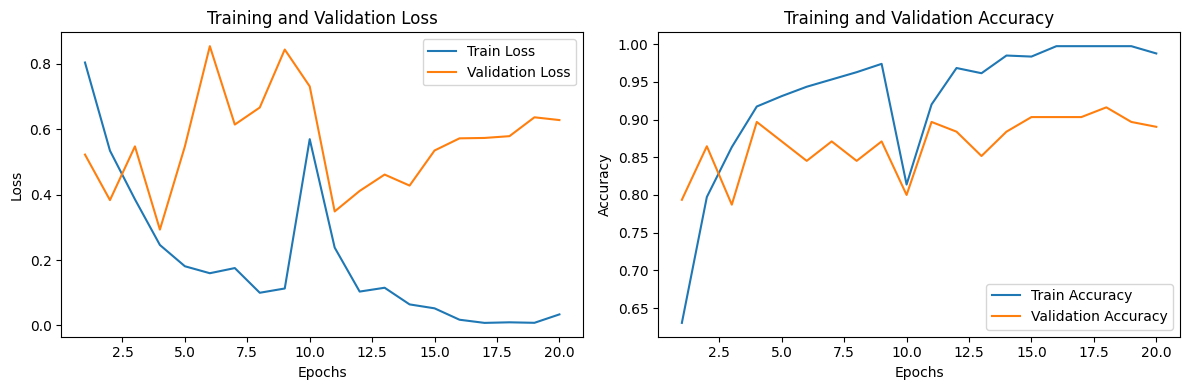

Training and Evaluating for VGG19!
-----------------------------------
Epoch 1/20 => Train Loss: 1.0269, Train Accuracy: 0.5007 | Val Loss: 0.7125, Val Accuracy: 0.7161
Epoch 2/20 => Train Loss: 0.6946, Train Accuracy: 0.6841 | Val Loss: 0.5678, Val Accuracy: 0.7484
Epoch 3/20 => Train Loss: 0.5872, Train Accuracy: 0.7586 | Val Loss: 0.4568, Val Accuracy: 0.8194
Epoch 4/20 => Train Loss: 0.5279, Train Accuracy: 0.8069 | Val Loss: 0.5811, Val Accuracy: 0.7871
Epoch 5/20 => Train Loss: 0.3960, Train Accuracy: 0.8497 | Val Loss: 0.5310, Val Accuracy: 0.8258
Epoch 6/20 => Train Loss: 0.2753, Train Accuracy: 0.9062 | Val Loss: 0.2919, Val Accuracy: 0.8903
Epoch 7/20 => Train Loss: 0.2344, Train Accuracy: 0.9131 | Val Loss: 0.2540, Val Accuracy: 0.9032
Epoch 8/20 => Train Loss: 0.2124, Train Accuracy: 0.9172 | Val Loss: 0.2847, Val Accuracy: 0.9161
Epoch 9/20 => Train Loss: 0.1619, Train Accuracy: 0.9421 | Val Loss: 0.4272, Val Accuracy: 0.9032
Epoch 10/20 => Train Loss: 0.1849, Train Accura

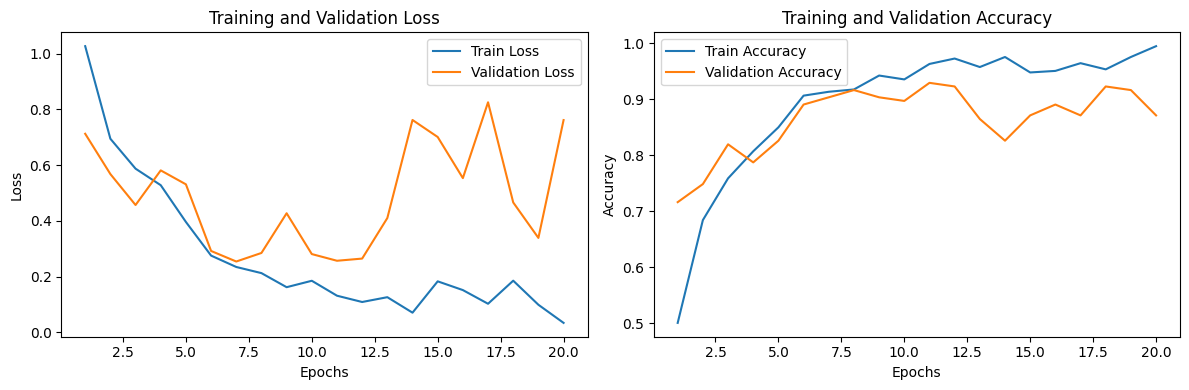

In [48]:
for model, name in models_dict.items():
    print(f'Training and Evaluating for {name}!')
    print('-'*35)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    trainer = Trainer(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        device=device
    ) # TODO
    trainer.train(train_dataloader, test_dataloader, num_epochs=20)

    metrics = trainer.get_metrics()

    # Test on Validation Set
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate accuracy
    accuracy = correct_predictions / total_samples
    print(f'Val Accuracy: {accuracy * 100:.2f}%')

    plot_metrics(metrics)


### Exercitiul 4
"Dezghețați" ultimele 20 de straturi ale fiecărui model și faceți fine-tuning.

Hint-uri:
1. model.features.children() returnează o listă a straturilor din secțiunea features a modelului
2. param.requires_grad = True setează flag-ul pentru fiecare strat, indicând că gradientul trebuie calculat pentru acest strat (permitând actualizarea parametrilor în timpul antrenării)

In [49]:
print('Fine-tuning the last 20 layers for each model')
print('-'*35)
for model, name in models_dict.items():
    num_layers_to_unfreeze = 20

    # Unfreeze the specified number of layers
    # TODO
    for param in model.parameters():
        param.requires_grad = False

    feature_layers = list(model.features.children())
    for layer in feature_layers[-num_layers_to_unfreeze:]:
        for param in layer.parameters():
            param.requires_grad = True

    model.to(device)
    print(f'The model {name} is ready!')
    print('-'*35)

Fine-tuning the last 20 layers for each model
-----------------------------------
The model VGG16 is ready!
-----------------------------------
The model VGG19 is ready!
-----------------------------------


Epoch 1/20 => Train Loss: 0.0975, Train Accuracy: 0.9834 | Val Loss: 1.1406, Val Accuracy: 0.8710
Epoch 2/20 => Train Loss: 0.0154, Train Accuracy: 0.9945 | Val Loss: 1.0598, Val Accuracy: 0.8645
Epoch 3/20 => Train Loss: 0.0408, Train Accuracy: 0.9848 | Val Loss: 0.9576, Val Accuracy: 0.8903
Epoch 4/20 => Train Loss: 0.0701, Train Accuracy: 0.9834 | Val Loss: 1.1074, Val Accuracy: 0.9032
Epoch 5/20 => Train Loss: 0.0221, Train Accuracy: 0.9959 | Val Loss: 1.1041, Val Accuracy: 0.9032
Epoch 6/20 => Train Loss: 0.0187, Train Accuracy: 0.9959 | Val Loss: 0.9166, Val Accuracy: 0.9097
Epoch 7/20 => Train Loss: 0.0069, Train Accuracy: 0.9972 | Val Loss: 1.1267, Val Accuracy: 0.8903
Epoch 8/20 => Train Loss: 0.0078, Train Accuracy: 0.9986 | Val Loss: 1.2544, Val Accuracy: 0.8839
Epoch 9/20 => Train Loss: 0.0019, Train Accuracy: 1.0000 | Val Loss: 0.9263, Val Accuracy: 0.9032
Epoch 10/20 => Train Loss: 0.0002, Train Accuracy: 1.0000 | Val Loss: 0.9126, Val Accuracy: 0.9097
Epoch 11/20 => Trai

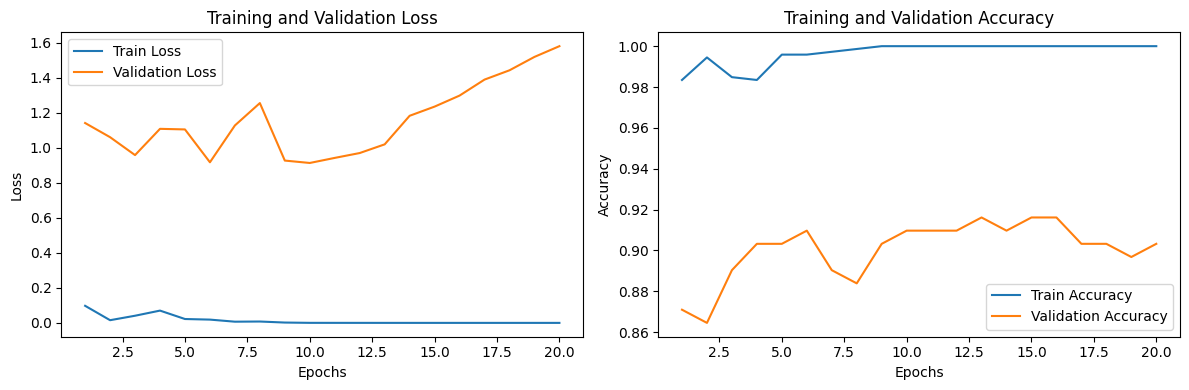

In [50]:
# reantrenati si testati doar pe VGG19
# TODO
criterion_vgg19 = nn.CrossEntropyLoss()
optimizer_vgg19 = optim.Adam(
    filter(lambda p: p.requires_grad, model_vgg19.parameters()),
    lr=1e-4
)

trainer_vgg19 = Trainer(
    model=model_vgg19,
    optimizer=optimizer_vgg19,
    criterion=criterion_vgg19,
    device=device
)

trainer_vgg19.train(train_dataloader, test_dataloader, num_epochs=20)

metrics_vgg19 = trainer_vgg19.get_metrics()

correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_vgg19(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

val_accuracy = correct_predictions / total_samples
print(f'VGG19 Val Accuracy: {val_accuracy * 100:.2f}%')

plot_metrics(metrics_vgg19)

## Partea 2 - Segmentare

In [51]:
images = [mask_images.replace("_mask", "") for mask_images in masks]
series = list(zip(images, masks))

In [52]:
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path'])
dataset

,image_path,mask_path
0,Dataset_BUSI_with_GT/benign/benign (27).png,Dataset_BUSI_with_GT/benign/benign (27)_mask.png
1,Dataset_BUSI_with_GT/benign/benign (53).png,Dataset_BUSI_with_GT/benign/benign (53)_mask.png
2,Dataset_BUSI_with_GT/benign/benign (24).png,Dataset_BUSI_with_GT/benign/benign (24)_mask.png
3,Dataset_BUSI_with_GT/benign/benign (304).png,Dataset_BUSI_with_GT/benign/benign (304)_mask.png
4,Dataset_BUSI_with_GT/benign/benign (166).png,Dataset_BUSI_with_GT/benign/benign (166)_mask.png
...,...,...
775,Dataset_BUSI_with_GT/malignant/malignant (133)...,Dataset_BUSI_with_GT/malignant/malignant (133)...
776,Dataset_BUSI_with_GT/malignant/malignant (80).png,Dataset_BUSI_with_GT/malignant/malignant (80)_...
777,Dataset_BUSI_with_GT/malignant/malignant (2).png,Dataset_BUSI_with_GT/malignant/malignant (2)_m...
778,Dataset_BUSI_with_GT/malignant/malignant (83).png,Dataset_BUSI_with_GT/malignant/malignant (83)_...


In [53]:
train, test= train_test_split(dataset, test_size=0.25)
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (585, 2)
Test shape: (195, 2)


In [54]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomImageMaskDataset(Dataset):
    np.random.seed(42)
    torch.manual_seed(42)
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        image = Image.open(image_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)

        return image, mask

image_size = 128

train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])


# Create datasets
train_dataset = CustomImageMaskDataset(train, train_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)

# Create DataLoaders
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [55]:
for batch in train_dataloader:
    inputs, targets = batch

    # Print the shapes
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [56]:
class ConvBlock(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(ConvBlock, self).__init__()
        self.conv2d_1 = nn.Conv2d(input_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(out_channel)
        self.relu_1 = nn.ReLU()

        self.dropout = nn.Dropout(dropout)

        self.conv2d_2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(out_channel)
        self.relu_2 = nn.ReLU()

    def forward(self, x):
        x = self.conv2d_1(x)
        x = self.batchnorm_1(x)
        x = self.relu_1(x)

        x = self.dropout(x)

        x = self.conv2d_2(x)
        x = self.batchnorm_2(x)
        x = self.relu_2(x)

        return x

class Encoder(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(Encoder, self).__init__()
        self.conv2d_1 = ConvBlock(input_channel, out_channel, dropout)
        self.maxpool = nn.MaxPool2d((2,2))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv2d_1(x)
        p = self.maxpool(x)
        p = self.dropout(p)

        return x, p

class Decoder(nn.Module):
    def __init__(self, input_channel, output_channel, dropout):
        super(Decoder, self).__init__()
        self.conv_t = nn.ConvTranspose2d(input_channel, output_channel, stride=2, kernel_size=2)
        self.conv2d_1 = ConvBlock(output_channel*2, output_channel, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, skip):
        x = self.conv_t(x)
        x = torch.cat([x, skip], dim=1)
        x = self.dropout(x)
        x = self.conv2d_1(x)

        return x

In [57]:
class Unet(nn.Module):

    def __init__(self, input_channel=1):
        super().__init__()
        self.encoder_1 = Encoder(input_channel, 64, 0.07)
        self.encoder_2 = Encoder(64, 128, 0.08)
        self.encoder_3 = Encoder(128, 256, 0.09)
        self.encoder_4 = Encoder(256, 512, 0.1)

        self.conv_block = ConvBlock(512, 1024, 0.11)

        self.decoder_1 = Decoder(1024, 512, 0.1)
        self.decoder_2 = Decoder(512, 256, 0.09)
        self.decoder_3 = Decoder(256, 128, 0.08)
        self.decoder_4 = Decoder(128, 64, 0.07)

        self.cls = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.relu = nn.Sigmoid()

    def forward(self, x):

        """ ------ Encoder ------"""
        x1, p1 = self.encoder_1(x)
        x2, p2 = self.encoder_2(p1)
        x3, p3 = self.encoder_3(p2)
        x4, p4 = self.encoder_4(p3)

        """ ------ BottleNeck ------"""
        x5 = self.conv_block(p4)

        """ ------ Decoder ------"""
        x6 = self.decoder_1(x5, x4)
        x7 = self.decoder_2(x6, x3)
        x8 = self.decoder_3(x7, x2)
        x9 = self.decoder_4(x8, x1)

        """ ------ Final Layer ------"""
        x_final = self.cls(x9)
        x_final = self.relu(x_final)

        return x_final


In [58]:
class Trainer:
    def __init__(self, model, num_epochs, optimizer, criterion, device):
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.model = model
        self.device = device
        self.log_interval = 15

        # Lists to store training and validation metrics
        self.train_losses = []
        self.val_losses = []
        self.train_dices = []
        self.val_dices = []

        # Best model and its metrics
        self.best_model = None
        self.best_dice = 0.0
        self.best_epoch = 0

    def dice_coeff(self, predicted, target, smooth=1e-5):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice = (2. * intersection + smooth) / (union + smooth)
        return dice

    def iou(self, pred_mask, true_mask):
        intersection = torch.logical_and(pred_mask, true_mask).sum().item()
        union = torch.logical_or(pred_mask, true_mask).sum().item()
        iou_score = intersection / union if union != 0 else 0.0
        return iou_score

    def save_best_model(self, epoch, dice):
        if dice > self.best_dice:
            self.best_dice = dice
            self.best_epoch = epoch
            self.best_model = self.model.state_dict()

            filename = f'best_model_epoch{epoch}_dice{dice:.4f}.pth'
            torch.save(self.best_model, filename)

    def train(self, train_loader, val_loader):
        for epoch in range(self.num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_dice = 0.0
            val_dice = 0.0

            # Training loop
            for i, (images, masks) in enumerate(train_loader):
                images, masks = images.to(self.device), masks.to(self.device)

                self.model.train()
                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                dice = self.dice_coeff(outputs, masks)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_dice += dice

                if (i + 1) % self.log_interval == 0:
                    print(f'Epoch [{epoch + 1}/{self.num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Dice Coef: {dice:.4f}')

            # Validation loop
            self.model.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(self.device), masks.to(self.device)
                    outputs = self.model(images)
                    val_loss += self.criterion(outputs, masks).item()
                    val_dice += self.dice_coeff(outputs, masks)

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            avg_train_dice = train_dice / len(train_loader)
            avg_val_dice = val_dice / len(val_loader)

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}')

            # Save metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_dices.append(avg_train_dice)
            self.val_dices.append(avg_val_dice)

            # Save best model
            self.save_best_model(epoch + 1, avg_val_dice)
    def get_metrics(self):
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_dices': self.train_dices,
            'val_dices': self.val_dices,
            'best_model': self.best_model,
            'best_dice': self.best_dice,
            'best_epoch': self.best_epoch
        }

## Exercitiul 5
Implementați funcția de loss Dice. Funcția trebuie să returneze valoarea 1 - coeficientul Dice. Coeficientul Dice este definit ca raportul dintre 2 x intersecția celor două seturi și uniunea acestora. Adăugați și la intersecție și uniune factorul „smooth” pentru a evita împărțirea la zero.

In [59]:
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    inputs_flat = inputs.view(-1)
    target_flat = target.view(-1)
    intersection = (inputs_flat * target_flat).sum() # TODO
    union = inputs_flat.sum() + target_flat.sum() # TODO
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice # TODO

def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()
    bce_score = bce_loss(inputs, target)

    return bce_score + dice_score

In [60]:
unet = Unet(1).to(device)

In [67]:
learning_rate = 0.0001
weight_decay = 1e-6  # Regularization term to prevent overfitting

optimizer = optim.Adam(unet.parameters(), lr=learning_rate, weight_decay=weight_decay)

trainer = Trainer(model=unet, num_epochs=5, optimizer=optimizer, criterion=bce_dice_loss, device=device)

In [68]:
# procesul de antrenare nu trebuie sa fie gata in timpul laboratorului
trainer.train(train_dataloader, test_dataloader)
metrics = trainer.get_metrics()

Epoch [1/5], Step [15/37], Loss: 0.4112, Dice Coef: 0.6860
Epoch [1/5], Step [30/37], Loss: 0.3531, Dice Coef: 0.7142
Epoch [1/5], Train Loss: 0.3569, Val Loss: 0.6069
Epoch [1/5], Train Dice: 0.7229, Val Dice: 0.5562
Epoch [2/5], Step [15/37], Loss: 0.3475, Dice Coef: 0.7053
Epoch [2/5], Step [30/37], Loss: 0.2851, Dice Coef: 0.7787
Epoch [2/5], Train Loss: 0.3377, Val Loss: 0.5830
Epoch [2/5], Train Dice: 0.7369, Val Dice: 0.5780
Epoch [3/5], Step [15/37], Loss: 0.2579, Dice Coef: 0.8092
Epoch [3/5], Step [30/37], Loss: 0.2512, Dice Coef: 0.8161
Epoch [3/5], Train Loss: 0.3393, Val Loss: 0.6000
Epoch [3/5], Train Dice: 0.7349, Val Dice: 0.5820
Epoch [4/5], Step [15/37], Loss: 0.5799, Dice Coef: 0.5374
Epoch [4/5], Step [30/37], Loss: 0.3016, Dice Coef: 0.7629
Epoch [4/5], Train Loss: 0.3157, Val Loss: 0.5717
Epoch [4/5], Train Dice: 0.7549, Val Dice: 0.5827
Epoch [5/5], Step [15/37], Loss: 0.2317, Dice Coef: 0.8258
Epoch [5/5], Step [30/37], Loss: 0.3259, Dice Coef: 0.7273
Epoch [5/5

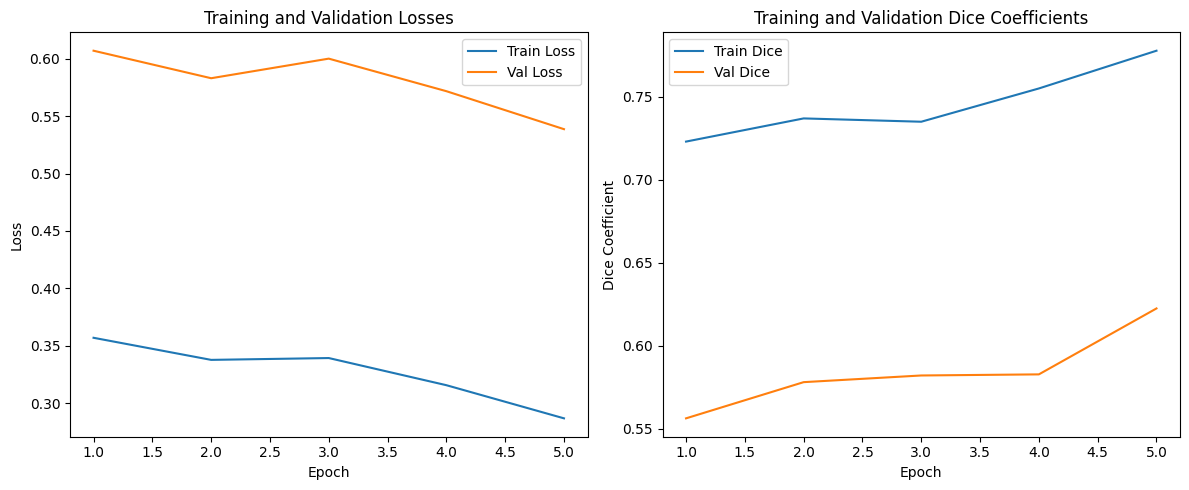

In [69]:
def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().item()

def plot_metrics(metrics):
    num_epochs = len(metrics['train_losses'])
    epochs = np.arange(1, num_epochs + 1)

    # Convert tensors to NumPy arrays
    train_losses_np = metrics['train_losses']
    val_losses_np = metrics['val_losses']
    train_dices_np = [to_numpy(dice) for dice in metrics['train_dices']]
    val_dices_np = [to_numpy(dice) for dice in metrics['val_dices']]

    # Plot Losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_np, label='Train Loss')
    plt.plot(epochs, val_losses_np, label='Val Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Dice Coefficients
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_dices_np, label='Train Dice')
    plt.plot(epochs, val_dices_np, label='Val Dice')
    plt.title('Training and Validation Dice Coefficients')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)


In [70]:
import matplotlib.pyplot as plt
import numpy as np

def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().numpy()

def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted

def plot_subplots(image, mask, predicted, threshold=0.5):
    # Convert tensors to NumPy arrays
    image_np, mask_np, predicted_np = map(to_numpy, (image, mask, predicted))

    # Threshold the predicted values
    predicted_np_thresholded = threshold_prediction(predicted_np, threshold)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Adjust figsize as needed

    # Plot Image, Mask, Predicted, and Thresholded Predicted
    titles = ['Image', 'Mask', 'Predicted']
    for ax, data, title in zip(axes, [image_np, mask_np, predicted_np, predicted_np_thresholded], titles):
        ax.imshow(data.squeeze(), cmap='gray' if 'Mask' in title else 'gray')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

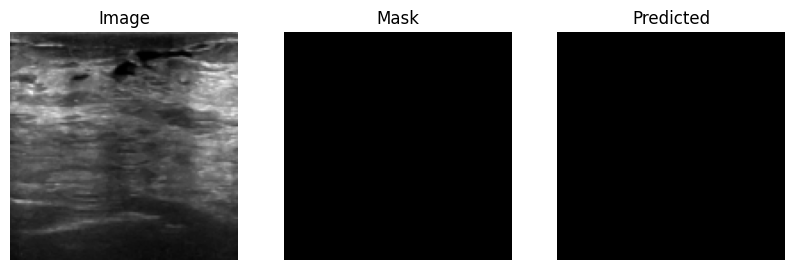

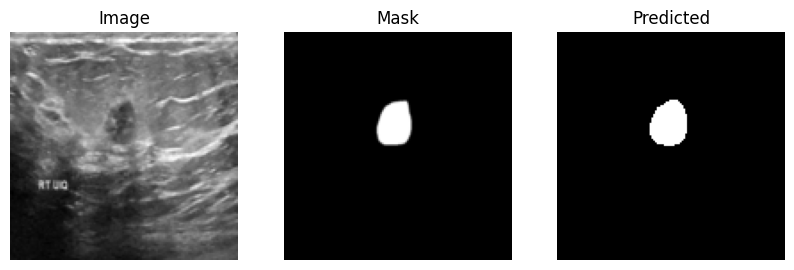

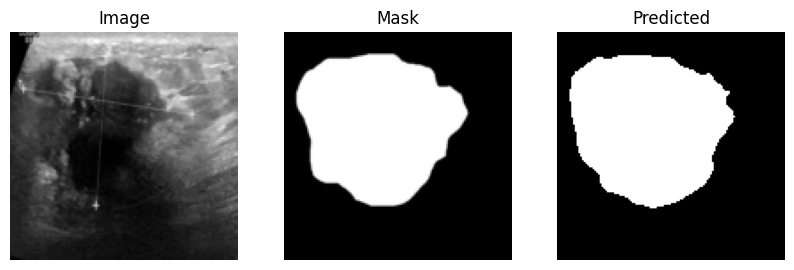

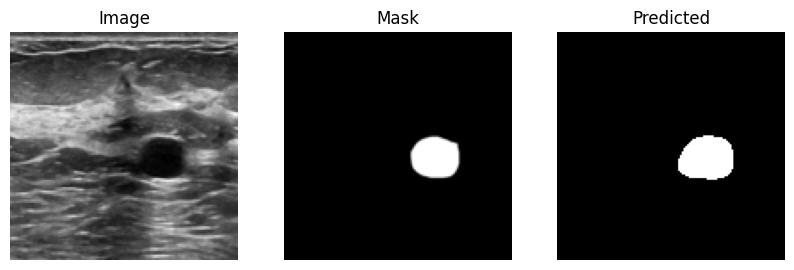

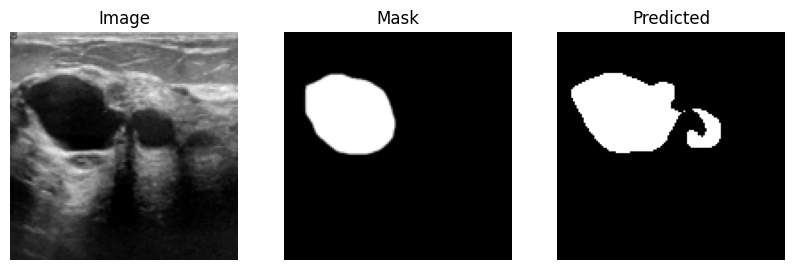

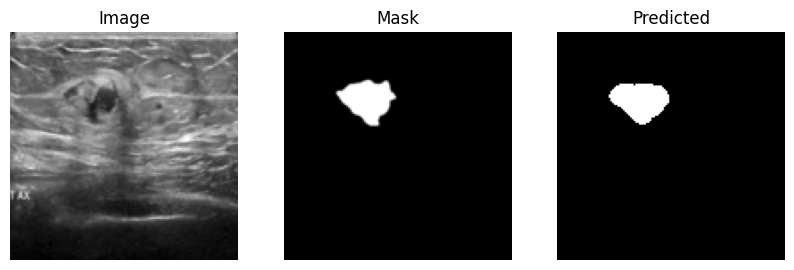

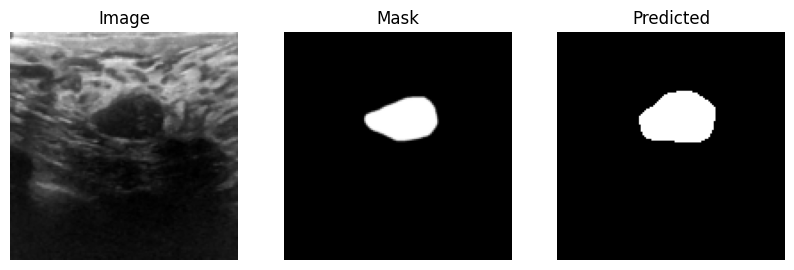

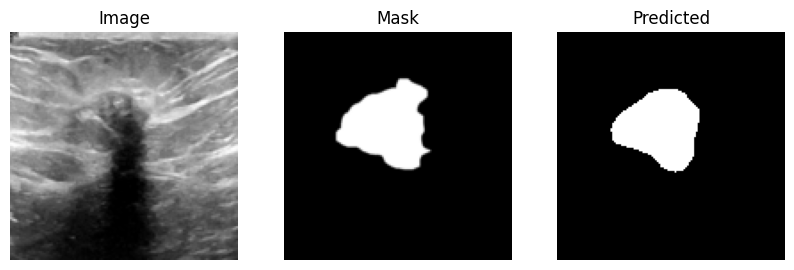

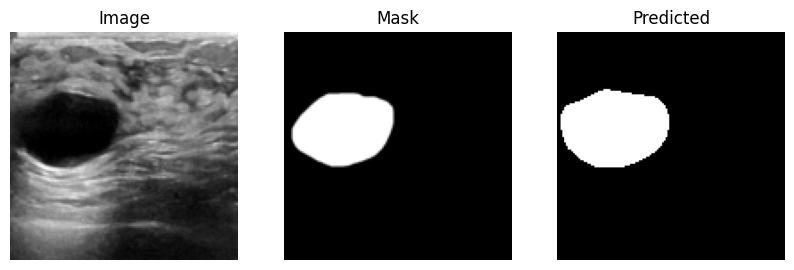

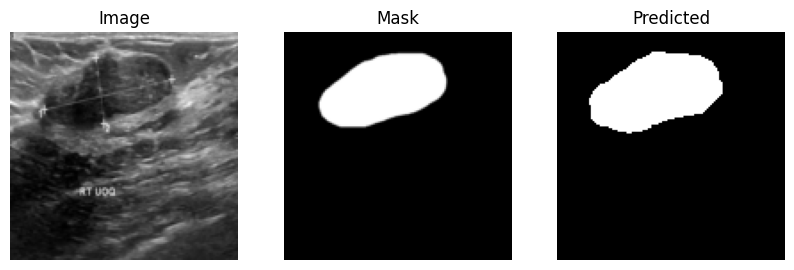

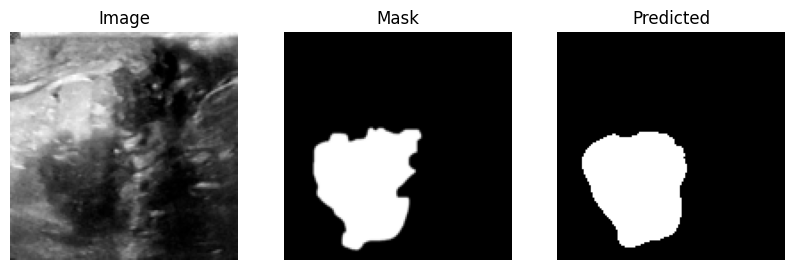

In [71]:
# testare
for i in [2, 3, 11, 20, 55, 67, 87, 98, 120, 130, 200]:
    image = train_dataset[i][0]
    mask = train_dataset[i][1]
    im = image.to(device)
    pred = unet(im.unsqueeze(0))
    pred = pred.squeeze()

    plot_subplots(im, mask, pred)